In [1]:
# import spacy
# import textacy 

In [19]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
import itertools as it
import pickle
import glob
import os
import string

from scipy import sparse

import nltk
import spacy

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, make_scorer
from sklearn.decomposition import TruncatedSVD

from scipy.optimize import minimize

import eli5
from IPython.display import display

import xgboost as xgb
from utils import *

In [2]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


### helper functions


In [38]:
def save_sparse_csr(fname, sm):
    np.savez(fname, 
             data=sm.data, 
             indices=sm.indices,
             indptr=sm.indptr, 
             shape=sm.shape)

def load_sparse_csr(fname):
    loader = np.load(fname)
    return sparse.csr_matrix((
        loader['data'], 
        loader['indices'], 
        loader['indptr']),
        shape=loader['shape'])

def plot_real_feature(fname):
    plt.rcParams['figure.figsize'] = 16, 12
    
    
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(df.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(df.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(df.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=df.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=df.loc[ix_train], 
                   ax=ax4)
    plt.show()

### load data

In [23]:
df = pd.read_csv("data/cache/extra_features_v2.csv")

In [36]:
ix_train = np.where(df['id'] >= 0)[0]
ix_test = np.where(df['id'] == -1)[0]
ix_is_dup = np.where(df['is_duplicate'] == 1)[0]
ix_not_dup = np.where(df['is_duplicate'] == 0)[0]

In [4]:
if os.path.isfile('tmp/m_q1_wl.npz') and os.path.isfile('tmp/m_q2_wl.npz'):
    m_q1 = load_sparse_csr('tmp/m_q1_wl.npz')
    m_q2 = load_sparse_csr('tmp/m_q2_wl.npz')
else:
    m_q1 = cv_words.transform([' '.join(s) for s in q1])
    m_q2 = cv_words.transform([' '.join(s) for s in q2])
    save_sparse_csr('tmp/m_q1_wl.npz', m_q1)
    save_sparse_csr('tmp/m_q2_wl.npz', m_q2)

### modeling

In [5]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False,  # <<< 
    smooth_idf=True, 
    sublinear_tf=False)




In [6]:
tf_transformed = tft.fit_transform(sparse.vstack((m_q1, m_q2)))



In [14]:
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

In [7]:
nmf = NMF(n_components=100, random_state=1,
          alpha=.1, l1_ratio=.5,init='nndsvd')

In [8]:
%%time
nmf.fit(tf_transformed)

CPU times: user 4h 51min 2s, sys: 14min 22s, total: 5h 5min 25s
Wall time: 4h 34min 30s


NMF(alpha=0.1, beta=1, eta=0.1, init='nndsvd', l1_ratio=0.5, max_iter=200,
  n_components=100, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [9]:
with open("data/cache/nmf_v1.bak",'w') as f:
    pickle.dump(nmf,f,pickle.HIGHEST_PROTOCOL)

In [13]:
nmf.components_.shape

(100, 113849)

In [15]:
%%time
m_q1_nmf = nmf.transform(m_q1_tf)
m_q2_nmf = nmf.transform(m_q2_tf)

CPU times: user 1h 56min 12s, sys: 2min 12s, total: 1h 58min 25s
Wall time: 1h 57min 14s


In [20]:
# save_array("data/cache/m_q1_nmf.dat",m_q1_nmf)

In [21]:
# save_array("data/cache/m_q2_nmf.dat",m_q2_nmf)

In [29]:
# m_q1_nmf[ix_train]

In [30]:
q1q2_zip = zip(m_q1_nmf,m_q2_nmf)

In [31]:
from scipy.spatial.distance import euclidean, cosine ,euclidean, minkowski, braycurtis,cityblock, jaccard, canberra
from scipy.linalg import norm



print ('creating euclidean_distance')
df['nmf_euclidean_distance'] = [euclidean(x, y) for (x, y) in q1q2_zip ]


print ('creating cosine_distance')
df['nmf_cosine_distance'] = [cosine(x, y) for (x, y) in q1q2_zip ]


print ('creating cityblock_distance')
df['nmf_cityblock_distance'] = [cityblock(x, y) for (x, y) in q1q2_zip ]

print ('creating jaccard_distance')
df['nmf_jaccard_distance'] = [jaccard(x, y) for (x, y) in q1q2_zip]

print ('creating canberra_distance')
df['nmf_canberra_distance'] = [canberra(x, y) for (x, y) in q1q2_zip]


print ('creating minkowski_distance')
df['nmf_minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in q1q2_zip]

print ('creating braycurtis_distance')
df['nmf_braycurtis_distance'] = [braycurtis(x, y) for (x, y) in q1q2_zip]

print ('creating hellinger_distance')
df['nmf_hellinger1_distance'] = [norm(np.sqrt(x) - np.sqrt(y)) / np.sqrt(2.0) for (x, y) in q1q2_zip]




creating euclidean_distance
creating cosine_distance
creating cityblock_distance
creating jaccard_distance
creating canberra_distance
creating minkowski_distance
creating braycurtis_distance
creating hellinger_distance


In [32]:
df.columns

Index([u'id', u'is_duplicate', u'qid1', u'qid2', u'question1', u'question2',
       u'test_id', u'1gr_cv_euclidean', u'1gr_cv_cosine', u'2gr_cv_euclidean',
       u'2gr_cv_cosine', u'3gr_cv_euclidean', u'3gr_cv_cosine',
       u'4gr_cv_euclidean', u'4gr_cv_cosine', u'1wl_tf_l2_cosine',
       u'1wl_tfidf_l1_euclidean', u'1wl_tf_l1_cosine', u'1wl_tf_l1_euclidean',
       u'w1g_tf_q1_q2_tf_svd0', u'w1g_tf_q1_q2_tf_svd1',
       u'w1g_vstack_svd_q1_q1_euclidean', u'w1g_vstack_svd_q1_q1_cosine',
       u'w1g_vsvd_cityblock_distance', u'w1g_vsvd_jaccard_distance',
       u'w1g_vsvd_canberra_distance', u'w1g_vsvd_minkowski_distance',
       u'w1g_vsvd_braycurtis_distance', u'w2g_vstack_svd_q1_q1_euclidean',
       u'w2g_vstack_svd_q1_q1_cosine', u'w2g_vsvd_cityblock_distance',
       u'w2g_vsvd_jaccard_distance', u'w2g_vsvd_canberra_distance',
       u'w2g_vsvd_minkowski_distance', u'w2g_vsvd_braycurtis_distance',
       u'nmf_euclidean_distance', u'nmf_cosine_distance',
       u'nmf_cityblo

ValueError: max must be larger than min in range parameter.

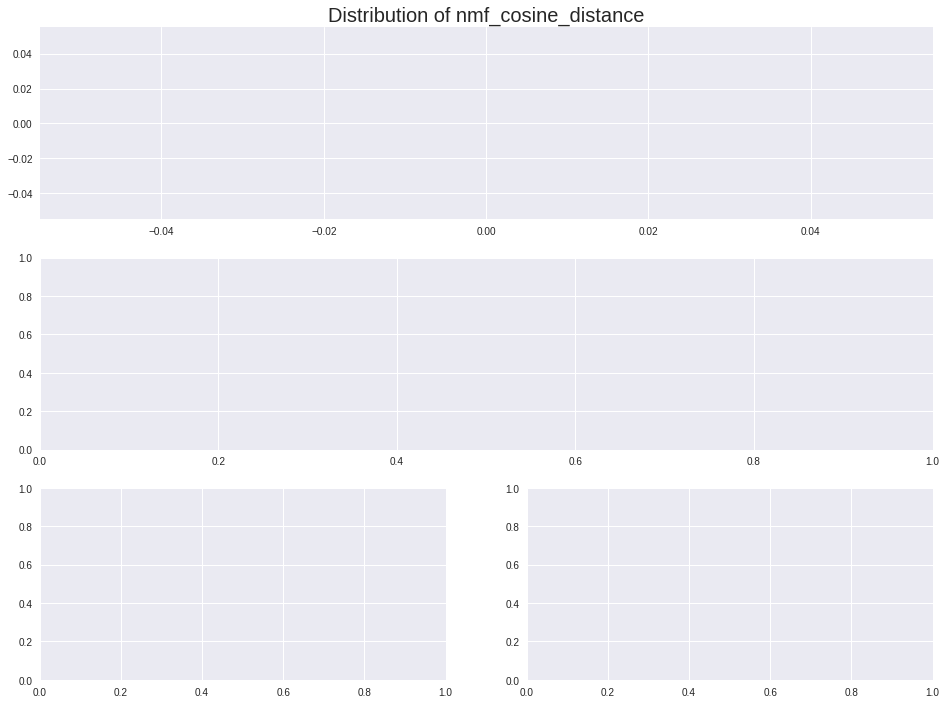

In [43]:
plot_real_feature('nmf_cosine_distance')

In [54]:
nmf_features = df[['id','is_duplicate','qid1', 'qid2','test_id',
                   'nmf_hellinger1_distance','nmf_braycurtis_distance',
                   'nmf_minkowski_distance','nmf_canberra_distance','nmf_jaccard_distance',
                  'nmf_cityblock_distance','nmf_cosine_distance','nmf_euclidean_distance']]

In [57]:
df.nmf_braycurtis_distance.isnull().sum()

5

In [58]:
nmf_features.to_csv("data/cache/nmf_features.csv",index=False)